In [1]:
from slim_gsgp_lib.main_slim import slim
from slim_gsgp_lib.utils.utils import train_test_split
from slim_gsgp_lib.utils.callbacks import *
from slim_gsgp_lib.evaluators.fitness_functions import rmse
import numpy as np
import torch
from sklearn.model_selection import KFold
import optuna
from sklearn.preprocessing import MinMaxScaler
import time
import os
from tqdm import tqdm
from functions.test_funcs import mape, nrmse, r_squared, mae, standardized_rmse
from matplotlib import pyplot as plt
from slim_gsgp_lib.algorithms.SLIM_GSGP.operators.mutators import *
from slim_gsgp_lib.algorithms.SLIM_GSGP.operators.simplifiers import *
from slim_gsgp_lib.utils.utils import *
from functions.test_algorithms import *
# from functions.random_search import * 
from slim_gsgp_lib.datasets.data_loader import *
import pickle

datasets = [globals()[i] for i in globals() if 'load' in i][2:]

TRY SIMPLIFY INDIVIDUAL USING THE VALIDATION SET 

+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|     dataset     |        it       |      train      |       test      |       time      |      nodes      |       div       |     avgStru     |      avgDep     |      struct     |     inflate     |     deflate     |        xo       |
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|       test      |        0        |      0.264      |      0.250      |      0.098      |        5        |    616818278    |      3.949      |      3.949      |     N/A (0)     |     N/A (0)     |     N/A (0)     |     N/A (0)     |
|-----------------|-----------------|-----------------|-

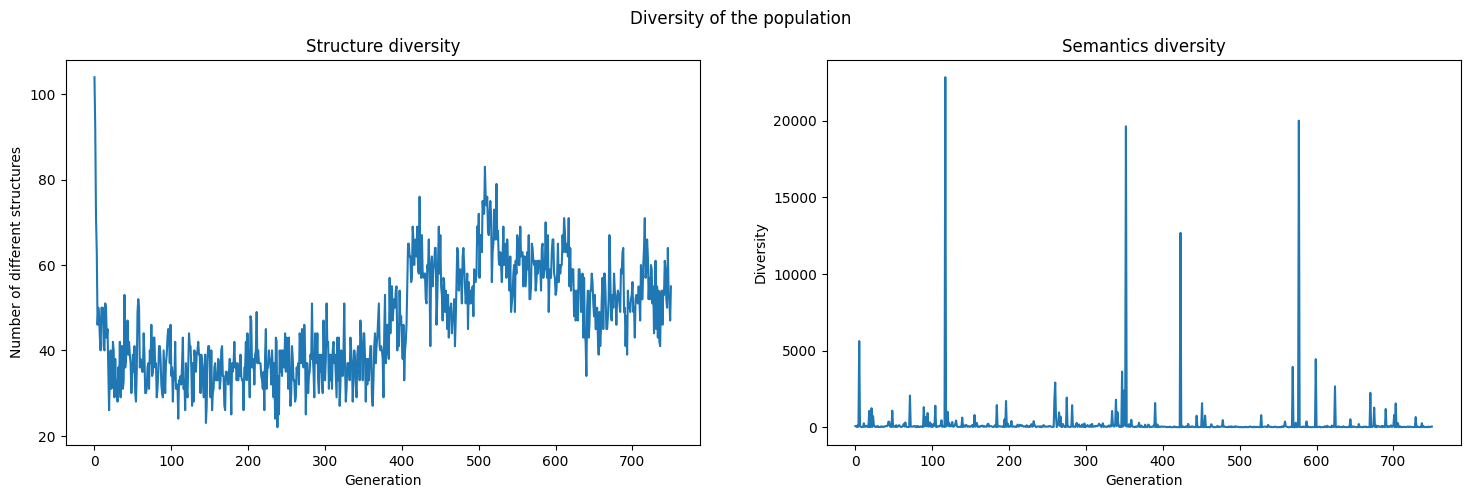

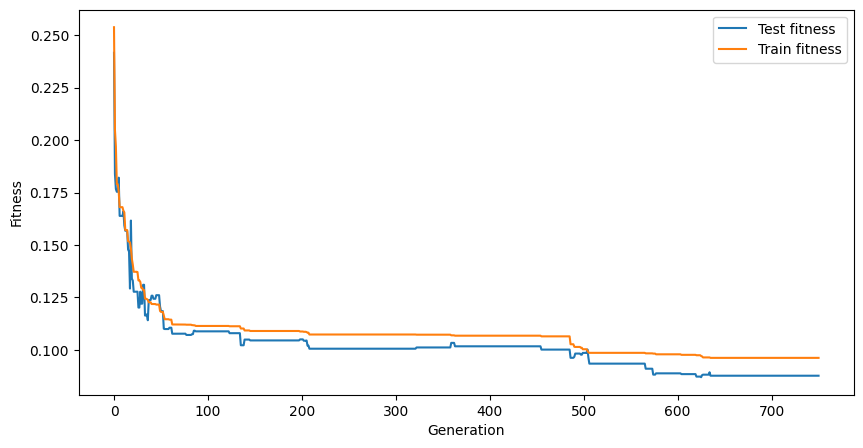

In [ ]:
seed = 0

X,y = datasets[7]()  # Concrete strenght dataset
# Scale
scaler_X, scaler_y = MinMaxScaler(), MinMaxScaler()
X_train, X_test, y_train, y_test = train_test_split(X, y, p_test=0.3, seed=0)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, p_test=0.5, seed=0)
X_train = torch.tensor(scaler_X.fit_transform(X_train))
y_train = torch.tensor(scaler_y.fit_transform(y_train.reshape(-1,1))).flatten()
X_val = torch.tensor(scaler_X.transform(X_val))
y_val = torch.tensor(scaler_y.transform(y_val.reshape(-1,1))).flatten()
X_test = torch.tensor(scaler_X.transform(X_test))
y_test = torch.tensor(scaler_y.transform(y_test.reshape(-1,1))).flatten()

agelog = LogAge()
divlog = LogDiversity()
fitlog = LogFitness()
early_stop = EarlyStopping_train(patience=115)

example_tree, population = slim(X_train=X_train, y_train=y_train, X_test=X_val, y_test=y_val,
                    dataset_name='test', test_elite=True, slim_version='SLIM*SIG1',
                    max_depth=21, init_depth=7, pop_size=175, n_iter=2000, seed=seed, fitness_sharing=False, verbose=1,
                    p_inflate=0.5, p_struct=0.25, # selector='lexicase', 
                    prob_const=0.125, struct_mutation=True, decay_rate=0, p_xo=0, 
                    callbacks=[agelog, divlog, fitlog, early_stop],
                    depth_distribution='uniform', tournament_size=3, full_return=True, timeout=200,
    )

preds = example_tree.predict(X_test)
print('RMSE:', rmse(preds, y_test))

divlog.plot_diversity()
fitlog.plot_fitness()

In [23]:
preds = example_tree.predict(X_test)
print('RMSE:', rmse(preds, y_test))
print('Nodes:', example_tree.nodes_count)

example_tree_ = simplify_individual(example_tree, y_val, X_val, threshold=0.01)
preds_ = example_tree_.predict(X_test)
print('RMSE:', rmse(preds_, y_test))
print('Nodes:', example_tree_.nodes_count)

RMSE: tensor(0.1002, dtype=torch.float64)
Nodes: 319
RMSE: tensor(0.1023, dtype=torch.float64)
Nodes: 240


In [40]:
seed = 0

X,y = datasets[13]()
# Scale
scaler_X, scaler_y = MinMaxScaler(), MinMaxScaler()
X = torch.tensor(scaler_X.fit_transform(X))
y = torch.tensor(scaler_y.fit_transform(y.reshape(-1,1)).reshape(-1))
X_train, X_test, y_train, y_test = train_test_split(X, y, p_test=0.2, seed=seed)

agelog = LogAge()
divlog = LogDiversity()

example_tree, population = slim(X_train=X_train, y_train=y_train, # X_test=X_test, y_test=y_test,
                    dataset_name='test', test_elite=False, slim_version='SLIM*SIG1',
                    max_depth=12, init_depth=4, pop_size=20, n_iter=2000, seed=seed, fitness_sharing=False, verbose=1,
                    p_inflate=0.4, p_struct=0.2, # selector='e_lexicase',
                    struct_mutation=True, decay_rate=0.1, p_xo=0, type_structure_mutation='new', callbacks=[agelog, divlog],
    )

preds = example_tree.predict(X_test)
print('RMSE:', rmse(preds, y_test))

+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|     dataset     |        it       |      train      |       test      |       time      |      nodes      |       div       |     avgStru     |      avgDep     |      struct     |     inflate     |     deflate     |        xo       |
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|       test      |        0        |      0.409      |       None      |      0.006      |        3        |       258       |      2.950      |      2.950      |     N/A (0)     |     N/A (0)     |     N/A (0)     |     N/A (0)     |
|-----------------|-----------------|-----------------|-

best 0.243070

In [2]:
def choose_depth(max_depth, random_index, mean=None, std_dev=None):
    # Calculate the available depths
    depth = max_depth - len(random_index)
    depths = np.arange(1, depth + 1) if len(random_index) > 1 else np.arange(2, depth + 1)
    
    # Set mean and standard deviation
    if mean is None:
        mean = depths.mean()  # Default mean: middle of the range
    if std_dev is None:
        std_dev = (depths[-1] - depths[0]) / 4
    
    # Generate probabilities using the normal distribution formula
    probabilities = np.exp(-((depths - mean) ** 2) / (2 * std_dev ** 2))
    probabilities /= probabilities.sum()  # Normalize
    
    # Choose a depth using the probabilities
    chosen_depth = random.choices(depths, weights=probabilities, k=1)[0]
    
    return chosen_depth

In [ ]:
def choose_depth(max_depth, random_index, mean=None, std_dev=None):
    # Calculate the available depths
    depth = max_depth - len(random_index)
    depths = np.arange(1, depth + 1) if len(random_index) > 1 else np.arange(2, depth + 1)
    
    # Set mean and standard deviation
    if mean is None:
        mean = depths.mean()  # Default mean: middle of the range
    if std_dev is None:
        std_dev = (depths[-1] - depths[0]) / 4
    
    # Generate probabilities using the normal distribution formula
    probabilities = np.exp(-((depths - mean) ** 2) / (2 * std_dev ** 2))
    probabilities /= probabilities.sum()  # Normalize
    
    # Choose a depth using the probabilities
    chosen_depth = random.choices(depths, weights=probabilities, k=1)[0]
    
    return chosen_depth

# Example usage
max_depth = 22
random_index = [1, 2,2,2,2,2]  # Example index

depths = []
for i in range(10000):
    depths.append(choose_depth(max_depth, random_index))
    
plt.hist(depths, bins=np.arange(1, max_depth + 1) - 0.5, rwidth=0.8)
plt.show()

In [2]:
seed = 0

X,y = datasets[10]()
# Scale
scaler_X, scaler_y = MinMaxScaler(), MinMaxScaler()
X = torch.tensor(scaler_X.fit_transform(X))
y = torch.tensor(scaler_y.fit_transform(y.reshape(-1,1)).reshape(-1))
X_train, X_test, y_train, y_test = train_test_split(X, y, p_test=0.2, seed=seed)

agelog = LogAge()
divlog = LogDiversity()

example_tree, population = slim(X_train=X_train, y_train=y_train, # X_test=X_test, y_test=y_test,
                    dataset_name='test', test_elite=False, slim_version='SLIM*SIG1',
                    max_depth=22, init_depth=10, pop_size=100, n_iter=100, seed=seed, fitness_sharing=False, verbose=1,
                    p_inflate=0.4, p_struct=0.2, selector='e_lexicase',
                    struct_mutation=False, decay_rate=0.1, p_xo=0, type_structure_mutation='new', callbacks=[agelog, divlog],
    )

preds = example_tree.predict(X_test)
print('RMSE:', rmse(preds, y_test))

+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|     dataset     |        it       |      train      |       test      |       time      |      nodes      |       div       |     avgStru     |      avgDep     |      struct     |     inflate     |     deflate     |        xo       |
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|       test      |        0        |      0.234      |       None      |      0.213      |        3        |    2128770183   |      4.910      |      4.910      |     N/A (0)     |     N/A (0)     |     N/A (0)     |     N/A (0)     |
|-----------------|-----------------|-----------------|-

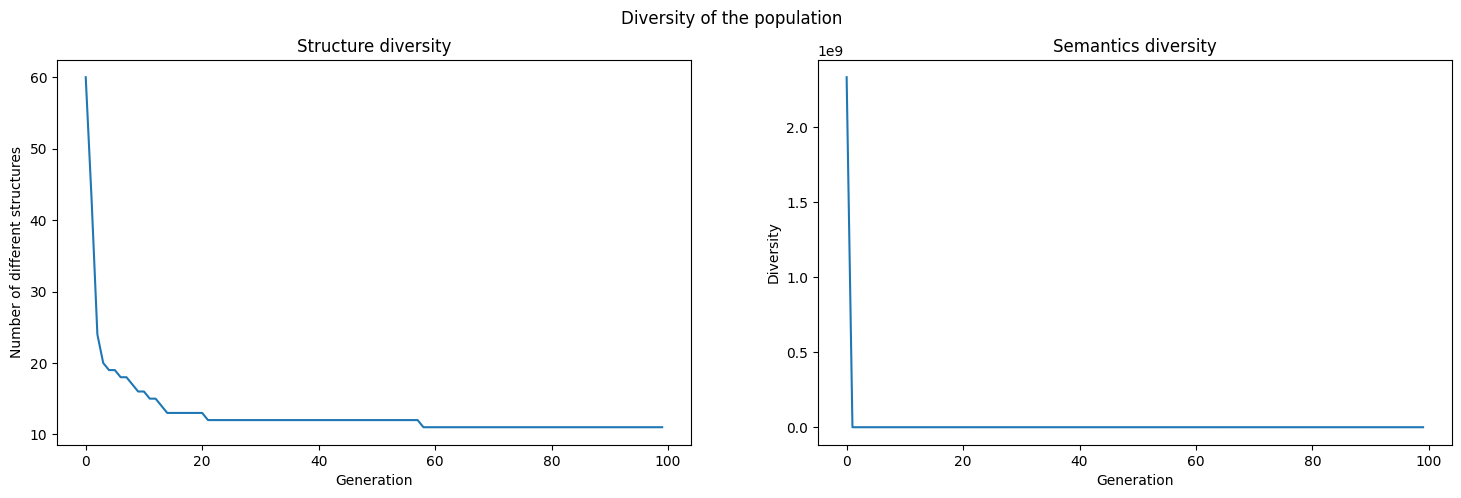

In [3]:
divlog.plot_diversity()

In [94]:
# Check the fitness for each individual
fitnesses = []

for tree in population.population:
    preds = tree.predict(X_test)
    fitnesses.append(rmse(preds, y_test))

# Get the 10 best fitnesses from the fitnesses list 
best_fitnesses = sorted(fitnesses)[:10]

# Get the ids 
best_ids = [fitnesses.index(i) for i in best_fitnesses]

ten_best = [population.population[i] for i in best_ids]

# Create a dataset and predict a linear model for the stacking ensemble
X_train_stacking = torch.zeros((X_train.shape[0], size))
X_test_stacking = torch.zeros((X_test.shape[0], size))

for i, tree in enumerate(ten_best):
    tree.version = 'SLIM*SIG1'
    X_train_stacking[:, i] = tree.predict(X_train)
    X_test_stacking[:, i] = tree.predict(X_test)
    
# Train a linear model
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train_stacking, y_train)

preds = lr.predict(X_test_stacking)
print('RMSE:', rmse(torch.tensor(preds), y_test))

RMSE: tensor(0.1013, dtype=torch.float64)


In [ ]:
constants = example_tree.collection[0].CONSTANTS
functions = example_tree.collection[0].FUNCTIONS
terminals = example_tree.collection[0].TERMINALS
depths = []

for i in range(10000):
    dep = choose_depth(14, [1,1,1,1])
    # dep = random.choice(np.arange(1, 14 + 1))
    # probs = exp_decay_prob(14, 0.3)
    # dep = random.choices(np.arange(1, 14 + 1), weights=probs, k=1)[0]
    if dep == 1:
        depths.append(1)
    else:
        depth = get_random_tree(max_depth=dep, 
                        FUNCTIONS=functions,
                        TERMINALS=terminals,
                        CONSTANTS=constants,
                        p_c=0.1).depth
        
        depths.append(depth)

plt.hist(depths, bins=np.arange(1, 14 + 1) - 0.5, rwidth=0.8)
plt.show()

In [15]:
indices_with_levels = get_indices_with_levels(example_tree.structure[0])
valid_indices_with_levels = [(index, level) for index, level in indices_with_levels if 22 - len(index) >= 2]


valid_indices, valid_levels = zip(*valid_indices_with_levels)
probs = exp_decay_prob(max(valid_levels) + 1, decay_rate=0.2)
level_probs = [probs[level] for level in valid_levels]
random_index = random.choices(valid_indices, weights=level_probs)[0]

In [4]:
indices_list = get_indices_with_levels(example_tree.structure[0])

In [ ]:
get_indices_with_levels(example_tree.structure[0])

In [ ]:
exp_decay_prob(5, decay_rate=0.3)

In [ ]:
decay_prob

In [17]:
counts_dict = {}

for i in range(10000):
    random_index = random.choices(indices_list, weights=decay_prob)[0]
    if random_index in counts_dict:
        counts_dict[random_index] += 1
    else:
        counts_dict[random_index] = 1

In [ ]:
counts_dict